In [3]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from subprocess import check_output 
import sys
from datetime import datetime
%matplotlib inline
os.chdir('/home/nitin.jain/selfproject/airbnb')

In [4]:
traindata=pd.read_pickle('X_train1')
testdata=pd.read_pickle('X_test1')
train_id_target=pd.read_pickle('train_id_target')
test_ids=pd.read_pickle('test_ids')

In [6]:
import xgboost as xgb
#Either use xgboost directly for training and predicting or use XGBClassifier which is a wrapper for for xgboost in sklearn to provide similar parameter names as used by other sklearn algorithms
#https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV 

In [62]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        extra = {'num_class': 12}
        xgb_param.update(extra)
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=train_id_target['target'])
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds,stratified = True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print("cross validation result")
        print(cvresult)
        
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train_id_target['target'],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_id_target['target'], dtrain_predictions))
    for i in range(0,12,1):
        print("AUC Score (Train) for class: %d is: %f" % (i,metrics.roc_auc_score(pd.Series((train_id_target['target']==i).astype(int)), dtrain_predprob[:,i])))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    print(feat_imp)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

cross validation result
     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              2.328645           0.000714             2.328213   
1              2.202485           0.001854             2.201684   
2              2.098169           0.002796             2.097022   
3              2.008426           0.003528             2.006930   
4              1.929479           0.003582             1.927675   
5              1.859595           0.003931             1.857528   
6              1.796762           0.004006             1.794425   
7              1.740558           0.003740             1.737870   
8              1.688846           0.004152             1.685875   
9              1.641605           0.004525             1.638364   
10             1.598252           0.004536             1.594764   
11             1.558449           0.004825             1.554685   
12             1.521151           0.004812             1.517090   
13             1.486597           0.00

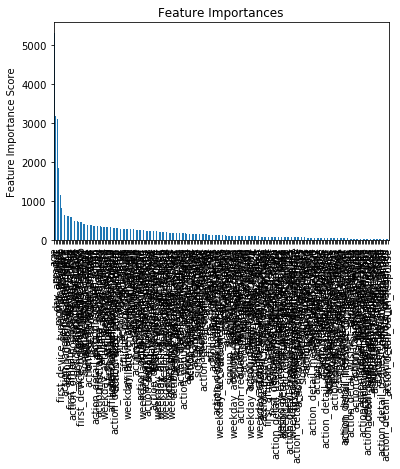

In [65]:
predictors = [x for x in traindata.columns if x not in ['target', 'IDcol']]
xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=10,
 gamma=0,
 subsample=1,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=8,
 #scale_pos_weight=1,
 seed=27)
modelfit(xgb1, traindata, predictors)

In [64]:
train_id_target['target'].value_counts()

7     47227
10    20439
11     3699
4      1461
6       994
5       741
3       714
1       450
2       255
8       251
0       152
9        83
Name: target, dtype: int64